# ASCII example

The model setup for this example is available in the following formats:

- ASCII
  - [](ascii_model.ascii)
  - [](ascii_data.ascii)
  - [](ascii_time.ascii)
  - [](ascii_commands.txt)

This example models the exact same model found in the basic example and runs the same optimization. However, in this script the model is defined in ASCII files and optimized by running a command file. pyshop provides methods for reading models from ASCII files and executing commands in command files. ASCII files have historically been the main method for defining Shop models, and command files have been used for executing commands on such ASCII models. In pyshop it is possible to combine the older approach with the newer python-based one.

## Imports and settings

The first thing we do is to import the needed packages. You can import whichever packages you like, however we use the following ones for this example:

- Pandas for structuring our data into dataframes
- pyshop in order to create a SHOP session
- Plotly backend for dynamic graph plotting

In [1]:
import pandas as pd
from pyshop import ShopSession
pd.options.plotting.backend = "plotly"

## Instancing SHOP

In order to have SHOP receive our inputs, run the model we create and give us results, we need to declare a running SHOP session, in this example to the instance 'shop'.

You may create multiple SHOP sessions simultaneously if needed.

In [2]:
# Creating a new SHOP session to the instance 'shop'
shop = ShopSession()

We might also want to check the current versions of SHOP and its solvers.

In [3]:
# Writing out the current version of SHOP
shop.shop_api.GetVersionString()

'17.8.4 Cplex 20.1.0 Gurobi 7.5 OSI/CBC 2.9 Armadillo 15.2.1 (Medium Roast Deluxe) Intel MKL 2023.0.0 2025 - 12 - 03'

## Reading ASCII files as input data

We make use of the read_ascii_file function to save data from file into the shop instance we created in the previous cell.
Note that it is important to import files in the correct order, meaning you cannot import something that relies on data that you have not imported from before.

The example of importing files below show best practice by

- First importing the data structure and indexing such as the time horizon and time period(s) of the model, and thus its data
- Furthermore importing the model topology and parameters
- Lastly populating the model with data and time series

Also note that the file(s) must be present in the same working directory/folder as the script/notebook that you are executing, if not using (absolute) paths.

### Reading and verifying time units

We start by importing the time period and time resolution from the file test_time.ascii.

In [4]:
# Importing the time period and time resolution
shop.read_ascii_file('ascii_time.ascii')

We then verify which time data has been read into the shop instance.

In [5]:
# Listing time resolution data from the model instance
shop.get_time_resolution()

{'starttime': Timestamp('2018-02-27 00:00:00'),
 'endtime': Timestamp('2018-02-28 00:00:00'),
 'timeunit': 'hour',
 'timeresolution': 2018-02-27    1.0
 Name: data, dtype: float64}

### Reading and verifying the topology and parameters

After the time structure has been correctly imported, we move on to importing the watercourse topology and its static parameters from the file test_model.ascii

In [6]:
# Importing the model's topology and assosiated parameters
shop.read_ascii_file('ascii_model.ascii')

We can then verify what has been read into the _shop_ instance by quering data using different get functions.

### List reservoirs and reservoir parameters in current model

In order to retrieve the current reservoir names in the model on the current _shop_ instance, we can use

In [7]:
# Listing the reservoirs in the current model
shop.model.reservoir.get_object_names()

['Reservoir1', 'Reservoir2']

Once we have verified the names, we can make use of them for more detailed queries, such as volume/head relations (stage-storage curves)

In [8]:
# Listing the volume/head relation in Reservoir1
shop.model.reservoir.Reservoir1.vol_head.get()

0.0      90.0
12.0    100.0
14.0    101.0
Name: 0.0, dtype: float64

In [9]:
# Listing the volume/head relation in Reservoir2
shop.model.reservoir.Reservoir2.vol_head.get()

0.0    40.0
5.0    50.0
6.0    51.0
Name: 0.0, dtype: float64

The flow descriptions

In [10]:
# Listing the overflow description in Reservoir1
shop.model.reservoir.Reservoir1.flow_descr.get()

100.0       0.0
101.0    1000.0
Name: 0.0, dtype: float64

Attributes like HRL and LRL, can just as easily be retrieved

In [11]:
# Listing the highest regulated level (HRL) in Reservoir1
shop.model.reservoir.Reservoir1.hrl.get()

100.0

In [12]:
# Listing the lowest regulated level (LRL) in Reservoir1
shop.model.reservoir.Reservoir1.lrl.get()

90.0

### List plants and plant parameters in current model

The same process is applicable for all other object types, such as plants. We can retrieve the current plant names

In [13]:
# Listing the plants in the current model
shop.model.plant.get_object_names()

['Plant1', 'Plant2']

And then verify what has been read into the model by querying attributes from the objects using the get functions

In [14]:
# Listing the number of generators on Plant1
shop.model.plant.Plant1.num_gen.get()

1

In [15]:
# Listing the penstock loss on Plant1
shop.model.plant.Plant1.penstock_loss.get()

[0.0001]

### List generators and generator parameters in current model

And again, if we want to verify the generators and its parameters, we can do use the same approach as above

In [16]:
# Listing the generators in the current model
shop.model.generator.get_object_names()

['Plant1_G1', 'Plant2_G1']

In [17]:
# Listing the number of generators on Plant1
shop.model.generator.Plant1_G1.turb_eff_curves.get()

[25.0     80.0
 90.0     95.0
 100.0    90.0
 Name: 90.0, dtype: float64,
 25.0     82.0
 90.0     98.0
 100.0    92.0
 Name: 100.0, dtype: float64]

Since the ascii file also included the connections between reservoirs, plants and generators, we can then verify if the topology is correctly set up, by graphing out the topology tree.

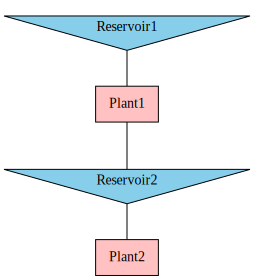

In [18]:
# Print out the topology
dot = shop.model.build_connection_tree()
display(dot)

### Reading and verifying the input data

After the topology and model structure has been set up correctly, we can populate additional data needed for SHOP to run, such as initial reservoir levels, endpoint descriptions (water values), market(s), inflow and other time dependent data, i.e. time series

In [19]:
# Importing other input data to the model
shop.read_ascii_file('ascii_data.ascii')

### List initial input data and time series

We can retrieve the newly imported static data out for inspection like before;

In [20]:
# Retrieve the start volume of Reservoir1
shop.model.reservoir.Reservoir1.start_vol.get()

0.0

In [21]:
# Retrieve the endpoint description (water value) of Reservoir1

shop.model.reservoir.Reservoir1.energy_value_input.get()

39.7

But now we are also introduced to time dependent data in time series

In [22]:
# Retrieve the inflow to Reservoir1
shop.model.reservoir.Reservoir1.inflow.get()

2018-02-27 00:00:00    101.0
2018-02-27 01:00:00     50.0
2018-02-27 02:00:00     50.0
2018-02-27 03:00:00     50.0
2018-02-27 04:00:00     50.0
2018-02-27 05:00:00     50.0
2018-02-27 06:00:00     50.0
2018-02-27 07:00:00     50.0
2018-02-27 08:00:00     50.0
2018-02-27 09:00:00     50.0
2018-02-27 10:00:00     50.0
2018-02-27 11:00:00     50.0
2018-02-27 12:00:00     50.0
2018-02-27 13:00:00     50.0
2018-02-27 14:00:00     50.0
2018-02-27 15:00:00     50.0
2018-02-27 16:00:00     50.0
2018-02-27 17:00:00     50.0
2018-02-27 18:00:00     50.0
2018-02-27 19:00:00     50.0
2018-02-27 20:00:00     50.0
2018-02-27 21:00:00     50.0
2018-02-27 22:00:00     50.0
2018-02-27 23:00:00     50.0
Name: inflow, dtype: float64

Which in many cases also can be useful to plot

In [23]:
# Plotting the inflow to Reservoir 1
shop.model.reservoir.Reservoir1.inflow.get().plot(title="Inflow to Reservoir 1", labels=dict(index="time", value="m3/s", variable=""))

For a complete overview of all objects and attributes you can query data from, see the [SHOP reference manual](https://sintefshop.no/documentation/reference/)'s [attribute section](https://sintefshop.no/documentation/reference/attributes/), or use a Language Server Protocol (LSP) in your IDE (which is included in the [Lab](https://sintefshop.no/lab/)) as illustrated below for an even easier and dynamic workflow.

![lsp.png](lsp.png)

## Running SHOP optimizations and commands from file

Once the model is fully imported and verified, we can then call for the optimizer. Since we now control all commands from a separate command file, this file needs to be inspected (and optinally altered and saved) before running the file in pyshop by using the _run_command_file_ command.

In [24]:
# Running the command file and executing SHOP based on the imported input
shop.run_command_file('.', 'ascii_commands.txt')

In this example, we chose CPLEX as the solver, enabled universal MIP and ran three full and three incremental iterations before we wrote the results to files.

For a full overview of the possible commands you can use when running SHOP, see the [SHOP reference manual](https://sintefshop.no/documentation/reference/)'s [command section](https://sintefshop.no/documentation/reference/commands/).

## Plotting the results

Finally, we can review the result from SHOP by plotting the graphs we want.

In [25]:
# Defining a plot dataframe to combine multiple time series in the same dataframe for plotting purposes (NB: they need to have the same time index)
plot = pd.DataFrame()

# Retrieving the reservoir trajectories adding them to the plot dataframe
plot["Reservoir1"]=shop.model.reservoir.Reservoir1.storage.get()
plot["Reservoir2"]=shop.model.reservoir.Reservoir2.storage.get()

# Plotting the figure
plot.plot(title="Reservoir trajectories", labels=dict(index="Time", value="Mm3", variable=""))

## Files

(ascii_model.ascii)=

### ascii_model.ascii

In [26]:
with open('ascii_model.ascii', 'r') as f:
    print(f.read())

RESERVOIR attributes Reservoir1
#ID;Water_course;Type;Maxvol;Lrl;Hrl;
10000       0      0  12.00000  90.00000  100.00000 

RESERVOIR vol_head Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
10000      0      0.000      9 MM3 METER
#  x_value;   y_value;
 0.00000  90.00000 
 12.00000  100.00000 
 14.00000  101.00000 

RESERVOIR flow_descr Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
10000      0      0.000      2 METER M3/S
#  x_value;   y_value;
 100.00000      0.000 
 101.00000   1000.000 

PLANT attributes Plant1 
#Id;Water_course;Type;Bid_area;Prod_area;Num_units;Num_pumps;
10500       0      0      1      1      1      0 
#Num_main_seg;Num_penstock;Time_delay;Prod_factor;Outlet_line;
     1      1      0      0.000     40.000 
#Main tunnell loss
0.0002
#penstock loss
0.0001

GENERATOR attributes Plant1 1 
#Id Type Penstock Nom_prod Min_prod Max_prod Start_cost 
10600 0      1     100.0      25.0     100.0   500.000 

GENERATOR gen_eff_curve Plant1 1 
#Id;Number;Reference;Pt

(ascii_data.ascii)=

### ascii_data.ascii

In [27]:
with open('ascii_data.ascii', 'r') as f:
    print(f.read())

STARTRES 	2  METER
# Name	Start reservoir(meters above sea level)
Reservoir1	92
Reservoir2	43

RESERVOIR	inflow	Reservoir1
#	Id	number	starttime		time_unit	period	data_type	y_unit	npts
	0	0	2018022700	HOUR		8760		-1	M3/S	1
#	time		y
2018022700	101
2018022701	50

RESERVOIR	inflow	Reservoir2
#	Id	number	starttime		time_unit	period	data_type	y_unit	npts
	0	0	2018022700	HOUR		8760		-1	M3/S	1
#	time		y
2018022700	0

RESERVOIR endpoint_desc Reservoir1
#	Number	Ref	Npkt	x_unit	y_unit
0	1	0	1	Mm3	Kroner
0	39.7

RESERVOIR endpoint_desc Reservoir2
#	Number	Ref	Npkt	x_unit	y_unit
0	1	0	1	Mm3	Kroner
0	38.6

MULTI_MARKET	price_buy	1
#	Id	number	starttime		time_unit	period	data_type	y_unit	npts
	0	0	2018022700	HOUR		8760		-1	M3/S	1
#	time		y
2018022700	40.01

MULTI_MARKET	price_sale	1
#	Id	number	starttime		time_unit	period	data_type	y_unit	npts
	0	0	2018022700	HOUR		8760		-1	M3/S	1
#	time		y
2018022700	39.99

MULTI_MARKET	max_buy	1
#	Id	number	starttime		time_unit	period	data_type	y_unit	npts
	0	0	

(ascii_time.ascii)=

### ascii_time.ascii

In [28]:
with open('ascii_time.ascii', 'r') as f:
    print(f.read())

OPTIMIZATION time
#Start_time;   End_time;
20180227	20180228

#    N_full_iterations   Accuracy;
OPTIMIZATION 100 -1
#Id  Number  Start_Time  Time_unit  Period  Data_type  Y_unit  Pts
	0	0	20180227	HOUR	525600	0	HOUR	1
# Time      Time_resolution
2018022700	1.000



(ascii_commands.txt)=

### ascii_commands.txt

In [29]:
with open('ascii_commands.txt', 'r') as f:
    print(f.read())

set solver /cplex

set universal_mip /on

start sim 3
set code /inc
start sim 3

return simres res.txt
return simres /gen res_gen.txt

